# Regressione in Python 

Boolean Data Week | 20 ottobre 2022


---

Per prima cosa carichiamo tutte le **librerie** che ci serviranno nell'analisi. 

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(11,7)})
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression

### Carichiamo i dati

Lavoreremo con un dataset contenente dati annuali (dal 2000 al 2012) relativi a degli indicatori socio-economici (come GDP, natalità, aspettativa di vita, ecc) di oltre 200 paesi in tutto il mondo. 

Carichiamo il dataset e diamogli una prima occhiata:

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/boolean-data-analytics/data/main/World%20Indicators%20S.csv')
df

,Country/Region,Region,Year,Population Total,GDP,CO2 Emissions,Energy Usage,Life Expectancy,Infant Mortality Rate
0,Algeria,Africa,01/12/2000,31719449,5.479006e+10,87931.0,26998.0,69.0,0.034
1,Angola,Africa,01/12/2000,13924930,9.129595e+09,9542.0,7499.0,45.5,0.128
2,Benin,Africa,01/12/2000,6949366,2.359122e+09,1617.0,1983.0,55.0,0.090
3,Botswana,Africa,01/12/2000,1755375,5.788312e+09,4276.0,1836.0,50.5,0.054
4,Burkina Faso,Africa,01/12/2000,11607944,2.610959e+09,1041.0,NaN,50.5,0.096
...,...,...,...,...,...,...,...,...,...
2686,Belize,The Americas,01/12/2012,324060,1.572500e+09,NaN,NaN,74.0,0.015
2687,Haiti,The Americas,01/12/2012,10173775,7.890217e+09,NaN,NaN,63.0,0.056
2688,Bolivia,The Americas,01/12/2012,10496285,2.703511e+10,NaN,NaN,67.0,0.032
2689,Honduras,The Americas,01/12/2012,7935846,1.856426e+10,NaN,NaN,73.5,0.020


### Analisi preliminare

Usiamo il metodo `.info()` per vedere le variabili incluse nel dataframe ed eventuali valori mancanti:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2691 entries, 0 to 2690
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country/Region         2691 non-null   object 
 1   Region                 2691 non-null   object 
 2   Year                   2691 non-null   object 
 3   Population Total       2691 non-null   int64  
 4   GDP                    2494 non-null   float64
 5   CO2 Emissions          2125 non-null   float64
 6   Energy Usage           1785 non-null   float64
 7   Life Expectancy        2555 non-null   float64
 8   Infant Mortality Rate  2444 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 189.3+ KB


Notiamo che la maggior parte delle variabili numeriche (ad eccezione di `Population Total`, contengono valori mancanti, in particolare `Energy Usage` è **la variabile con il più alto numero di valori nulli** (1785 su 2691, circa il 66%). 

Quando incontriamo dei valori mancanti, di fatto ci sono tre cose che possiamo fare per affrontare il problema: 

*   lasciare il valore mancante dov'è
*   eliminare l'osservazione (cioè l'intera riga)
*   **inserire un altro valore al posto di quello nullo**

Quest'ultima opzione può essere affrontata seguendo diverse strade: 

*   inserire un valore predeterminato (ad esempio lo 0)
*   inserire un valore medio globale (ad esempio la media della variabile)
*   inserire il valor medio delle ultime "n" osservazioni (nel caso in cui sussista un legame temporale tra le osservazioni della variabile) 
*   interpolazione dei dati
*   **regressione**

Noi ci concentreremo su quest'ultima tecnica, che è sicuramente la più complessa ma anche la più interessante e sta alla base degli algoritmi di apprendimento statistico (machine learning). 

Iniziamo guardando alla relazione tra queste due variabili rappresentandole graficamente con un grafico a dispersione (o **scatterplot**):

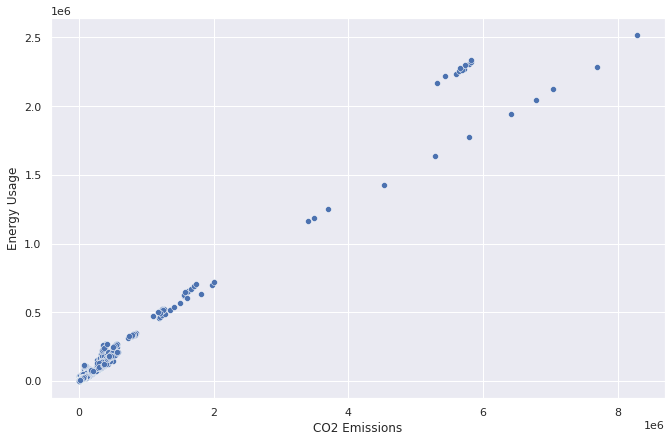

In [ ]:
sns.scatterplot(data=df, x='CO2 Emissions', y='Energy Usage')
plt.show()

Dallo scatterplot vediamo che c'è una **forte relazione lineare diretta** tra le due variabili, infatti notiamo che all'aumentare di una aumenta anche l'altra in maniera proporzionale. Potremmo quindi pensare di **costruire un modello** (di fatto un'equazione) il quale, data una variabile, sia in grado di prevedere la seconda.  

Diamo un'occhiata alla distribuzione dei valori nulli tra le due variabili:

In [ ]:
print(f"Entrambe nulle: {df[df['CO2 Emissions'].isna() & df['Energy Usage'].isna()].shape[0]}")
print(f"Solo 'CO2 Emissions' nulla: {df[df['CO2 Emissions'].isna() & df['Energy Usage'].notna()].shape[0]}")
print(f"Solo 'Energy Usage' nulla: {df[df['CO2 Emissions'].notna() & df['Energy Usage'].isna()].shape[0]}")
print(f"Entrambe non nulle: {df[df['CO2 Emissions'].notna() & df['Energy Usage'].notna()].shape[0]}")

Entrambe nulle: 376
Solo 'CO2 Emissions' nulla: 190
Solo 'Energy Usage' nulla: 530
Entrambe non nulle: 1595


In [ ]:
# bonus: un modo per mettere le informazioni riportate qua sopra in una 
#        tabella a doppia entrata:
co2_nrg_00 = df[df['CO2 Emissions'].isna() & df['Energy Usage'].isna()].shape[0]
co2_nrg_10 = df[df['CO2 Emissions'].notna() & df['Energy Usage'].isna()].shape[0]
co2_nrg_01 = df[df['CO2 Emissions'].isna() & df['Energy Usage'].notna()].shape[0]
co2_nrg_11 = df[df['CO2 Emissions'].notna() & df['Energy Usage'].notna()].shape[0]
pd.DataFrame([[co2_nrg_00, co2_nrg_10], 
              [co2_nrg_01, co2_nrg_11]], 
    columns=[['CO2', 'CO2'], 
             ['null','not-null']], 
    index=[['Energy', 'Energy'], 
           ['null','not-null']]
)

CO2         
                null not-null
Energy null      376      530
       not-null  190     1595

Dallo specchietto che abbiamo costruito qua sopra, notiamo che ci sono 530 osservazioni in cui il valore di `Energy Usage` non c'è, ma quello di `CO2 Emissions` sì. 

L'idea è quella di usare il modello che costruiremo per prevedere i valori mancanti di `Energy Usage` con i valori disponibili di `CO2 Emissions`. 

Creiamo un nuovo dataframe dove rimuoviamo tutte le righe che hanno anche solo un valore mancante; in questo modo otteniamo il seguente dataset che non contiene valori nulli e con il quale andremo a stimare un modello di regressione lineare:

In [ ]:
df_reg = df[['Country/Region', 'Region', 'Year', 'CO2 Emissions', 'Energy Usage']].dropna(how='any')
df_reg

,Country/Region,Region,Year,CO2 Emissions,Energy Usage
0,Algeria,Africa,01/12/2000,87931.0,26998.0
1,Angola,Africa,01/12/2000,9542.0,7499.0
2,Benin,Africa,01/12/2000,1617.0,1983.0
3,Botswana,Africa,01/12/2000,4276.0,1836.0
6,Cameroon,Africa,01/12/2000,3432.0,6310.0
...,...,...,...,...,...
2598,Nicaragua,The Americas,01/12/2010,4547.0,2951.0
2599,Bolivia,The Americas,01/12/2010,15456.0,7341.0
2600,Haiti,The Americas,01/12/2010,2120.0,2409.0
2601,Honduras,The Americas,01/12/2010,8108.0,4567.0


### Regressione Lineare - parte 1
*Un po' di teoria e un esempio semplice*

La **regressione lineare** è una tecnica largamente utilizzata in statistica e data science che permette di usare una o più variabili (dette variabili indipendenti o **regressori**) per prevedere il valore di un'ulteriore variabile d'interesse (detta variabile dipendente o **target**). 

Per fare ciò è necessario costruire un **modello** matematico, in particolare bisognerà trovare un'equazione che approssimi nel miglior modo possibile la relazione che sussiste tra i regressori e la variabile target. 

Ma vediamo subito un esempio pratico. Il seguente dataframe contiene dei dati fittizi su misurazioni di peso e altezza di 10 persone: 

In [ ]:
dati = pd.DataFrame(data = {'altezza':[175, 170, 172, 185, 165, 183, 182, 191, 178, 162], 
                            'peso':[68, 65, 63, 86, 60, 70, 80, 89, 74, 64]})
dati

,altezza,peso
0,175,68
1,170,65
2,172,63
3,185,86
4,165,60
5,183,70
6,182,80
7,191,89
8,178,74
9,162,64


Se rappresentiamo queste due variabili con un grafico a dispoersione, notiamo che ciascuna osservazione sembra essere allineata su un'ipotetica retta che, partendo dall'angolo in basso a sinistra, passa attraverso la nuvola di punti e continua fino all'angolo in alto a sinistra: 

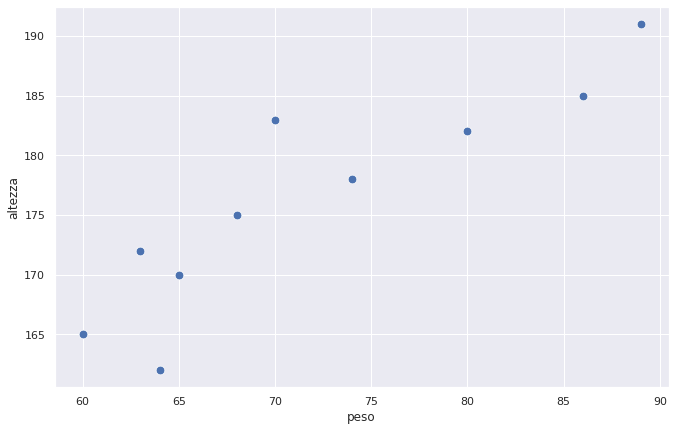

In [ ]:
sns.scatterplot(data=dati, x='peso', y='altezza', s=75)
plt.show()

Rispolverando qualche ricordo dalle scuole superiori, l'**equazione di una retta** è data da **`Y = a + bX`**:

<img src="https://drive.google.com/uc?export=view&id=1E4sarMiTkUM7VgRPqOt7gsArjnJDEy2V" width="800">

*Nota: forse qualcuno ricorderà l'equazione espressa come `Y = mX + q`*, ma in realtà la differenza è solo nella notazione, infatti se andiamo a sostituire `q = a` e `m = b`, otteniamo l'equazione dell'immagine sopra: `Y = a + bX`.

Quindi l'obiettivo della regressione lineare è quello di trovare l'equazione della retta che **approssima al meglio** la nuvola di punti (cioè i dati). 

Che cosa vuol dire "la retta che approssima al meglio"? L'idea centrale è che la distanza di ciascun punto dalla retta (cioè l'errore) deve essere la più corta possibile e quindi, tecnicamente, dovremo andare a cercare quella retta che **minimizza la somma delle distanze** tra punto e retta (le linee rosse nell'immagine qui sotto) al quadrato. 

<img src="https://drive.google.com/uc?export=view&id=1KyspQ_ANAcgPCofwSBlnIB7oOe2vx9ut" width="800">

> Facciamoci aiutare da [questo sito interattivo](https://mlu-explain.github.io/linear-regression/) per avere un'intuizione migliore di quanto visto finora.



A questo punto vediamo **come creare un modello di regressione lineare in Python** usando i nostri dati su peso e altezza. Nello specifico, creeremo un modello che, dato il peso (regressore o variabile indipendente) riesca a prevedere l'altezza (target o variabile dipendente) di una persona.

Il pacchetto `sklearn` contiene dei moduli che fanno al caso nostro e, in poche righe di codice, potremo creare il nostro modello: 

In [ ]:
# per ricordarci come sono fatti i nostri dati
dati.head()

,altezza,peso
0,175,68
1,170,65
2,172,63
3,185,86
4,165,60


In [ ]:
# importiamo la libreria che ci servirà per creare il modello di regressione lineare
from sklearn.linear_model import LinearRegression

In [ ]:
# definiamo e "fittiamo" il modello di regressione lineare
reg = LinearRegression()   # initialise the object
reg.fit(X = dati['peso'].values.reshape(-1, 1),   # fit the model
        y = dati['altezza'])

LinearRegression()

In [ ]:
# stampiamo a schermo i coefficienti della regressione
print(f'Intercetta (b0): {round(reg.intercept_, 2)}')
print(f'Coefficiente (b1): {round(reg.coef_[0], 2)}')

Intercetta (b0): 117.47
Coefficiente (b1): 0.82


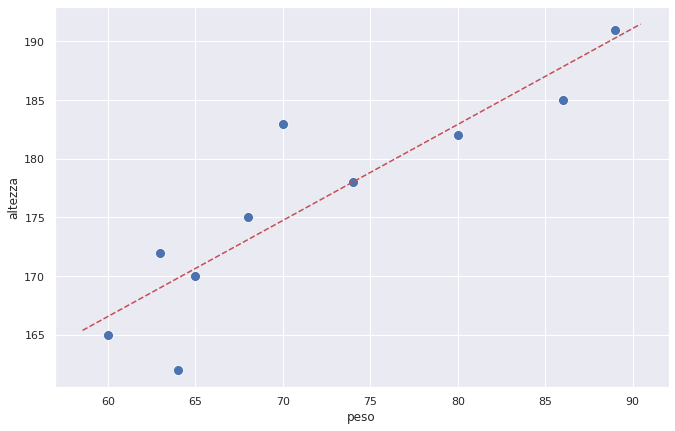

In [ ]:
# andiamo a rappresentare graficamente la retta che identifica il modello
# e la sovrapponiamo alla nuvola di punti dei nostri dati
sns.scatterplot(x='peso', y='altezza', data=dati, s = 100)

axes = plt.gca()   # get current axes instance
x_vals = np.array(axes.get_xlim())   # creiamo i dati per l'asse x
y_vals = reg.intercept_ + reg.coef_[0] * x_vals   # creiamo i dati per l'asse y 
plt.plot(x_vals, y_vals, '--', color='r')   # disegnamo la retta sopra allo scatterplot

plt.show()

L'equazione del nostro modello è data da: 

```
altezza = 0.82 * peso + 117.47 
```

Quindi, se dovessimo incontrare una nuova persona, **grazie a questo modello** potremmo **prevedere la sua altezza** a patto di conoscerne il peso. 

Ad esempio, per una persona che pesa 73 Kg potrà essere stimata un'altezza pari a 

```
altezza = 0.82 * 73 + 117.47 = 177.33
```

È anche possibile usare direttamente i coefficienti `reg.coef_` e `reg.intercept_` per ottenere una stima più precisa:

In [ ]:
previsione = reg.coef_[0] * 73 + reg.intercept_
print(f'Altezza prevista: { round(previsione, 2) }')

Altezza prevista: 177.2


Se andiamo a rappresentare la nuova osservazione `(73, 177.2)` sul grafico di prima, notiamo come l'osservazione si va a posizionare esattamente sulla retta di regressione, la quale **è essa stessa il nostro modello**! Infatti, qualsiasi previsione faremo con questo modello, si collocherà su tale retta. 

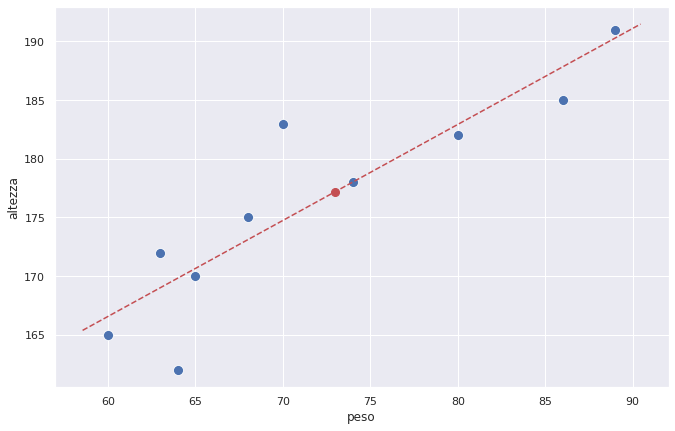

In [ ]:
sns.scatterplot(x='peso', y='altezza', data=dati, s=100)

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = reg.intercept_ + reg.coef_[0] * x_vals
plt.plot(x_vals, y_vals, '--', color='r')

plt.plot(73, previsione, 'o', color='r', markersize=8)   # aggiungiamo il nuovo punto (73, 177.2)

plt.show()

Se invece di avere una sola osservazione del peso per la quale vogliamo stimare l'altezza ne avessimo 5, potremmo usare il metodo `.predict()` per ottenere le nostre previsioni: 

In [ ]:
 x_prev = np.array([63, 67, 71, 82, 87])
 y_prev = reg.predict(x_prev.reshape(-1, 1))
 y_prev 

array([169.01800417, 172.29081129, 175.5636184 , 184.56383796,
       188.65484685])

Notiamo ancora come tutte le nostre previsioni siano collocate esattamente sulla retta di regressione (tratteggiata in rosso): 

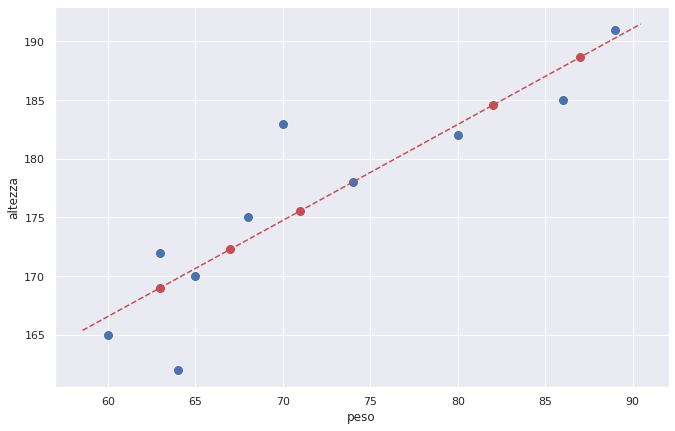

In [ ]:
sns.scatterplot(x='peso', y='altezza', data=dati, s=100)

intercept = reg.intercept_
slope = reg.coef_[0]

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color='r')

plt.plot(x_prev, y_prev, 'o', color='r', markersize=8)

plt.show()

### Regressione Lineare  - parte 2
*Applichiamo quanto visto al nostro esempio di partenza*

Ora che abbiamo un'idea più chiara di che cosa sia (e come si faccia) una regressione lineare, **torniamo al nostro dataset di partenza**: 

In [ ]:
df_reg.head(3)

,Country/Region,Region,Year,CO2 Emissions,Energy Usage
0,Algeria,Africa,01/12/2000,87931.0,26998.0
1,Angola,Africa,01/12/2000,9542.0,7499.0
2,Benin,Africa,01/12/2000,1617.0,1983.0


Creiamo un modello di regressione lineare, dove `Energy Usage` è la nostra variabile dipendente (quella che vogliamo prevedere) e `CO2 Emissions` è la nostra variabile indipendente (quella che vogliamo usare per prevedere `Energy Usage`): 

```
Energy Usage = b1 * CO2 Emissions + b0
```

In [ ]:
reg = LinearRegression()
reg.fit(X = df_reg['CO2 Emissions'].values.reshape(-1, 1), 
        y = df_reg['Energy Usage'])

LinearRegression()

Coefficiente e intercetta della regressione sono:

In [ ]:
print(f'Intercept: {reg.intercept_}')
print(f'Slope: {reg.coef_[0]}')

Intercept: 7850.367124299664
Slope: 0.3559106792770743


Disegnamo la retta di regressione sulla nuvola di punti dei nostri dati: 

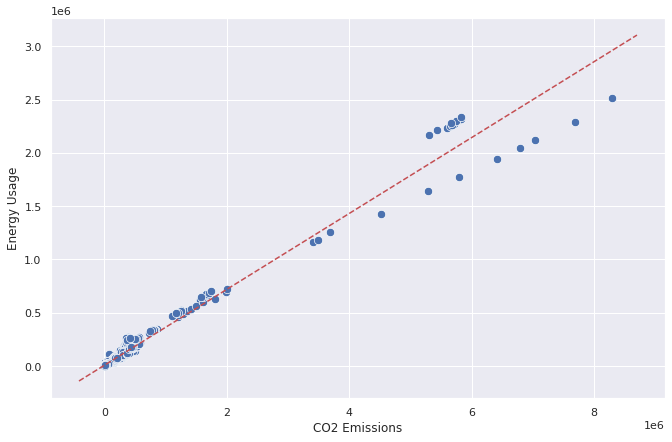

In [ ]:
sns.scatterplot(x='CO2 Emissions', y='Energy Usage', data=df_reg, s=70)

intercept = reg.intercept_
slope = reg.coef_[0]

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color='r')

plt.show()

Ora che abbiamo un modello, possiamo usarlo per andare a imputare i valori mancanti di `Energy Usage` (la `Y` o variabile target) andandoli a prevedere grazie ai valori noti di `CO2 Emissions` (la `X` o regressore, detto anche predittore). 

Per prima cosa, andiamo a isolare le osservazioni che hanno valore nullo di `Energy Usage` e non nullo di `CO2 Emissions`:

In [ ]:
df_pred = df[(df['Energy Usage'].isna()) & (df['CO2 Emissions'].notna())]
df_pred

,Country/Region,Region,Year,Population Total,GDP,CO2 Emissions,Energy Usage,Life Expectancy,Infant Mortality Rate
4,Burkina Faso,Africa,01/12/2000,11607944,2.610959e+09,1041.0,NaN,50.5,0.096
5,Burundi,Africa,01/12/2000,6674286,8.704861e+08,301.0,NaN,48.0,0.092
7,Central African Republic,Africa,01/12/2000,3638316,9.145003e+08,268.0,NaN,43.5,0.113
8,Chad,Africa,01/12/2000,8301151,1.385058e+09,176.0,NaN,47.0,0.106
9,Comoros,Africa,01/12/2000,528312,2.018999e+08,84.0,NaN,57.5,0.073
...,...,...,...,...,...,...,...,...,...
2583,Antigua and Barbuda,The Americas,01/12/2010,87233,1.135556e+09,513.0,NaN,75.5,0.009
2585,Suriname,The Americas,01/12/2010,524960,4.368034e+09,2384.0,NaN,70.5,0.022
2586,Grenada,The Americas,01/12/2010,104677,7.711111e+08,260.0,NaN,72.5,0.012
2593,Guyana,The Americas,01/12/2010,786126,2.259288e+09,1701.0,NaN,65.5,0.032


Creiamo le previsioni e le salviamo in una `pandas` [Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) (in `pandas`, le colonne di un DataFrame sono di fatto delle Series):

In [ ]:
predictions = reg.predict(df_pred['CO2 Emissions'].values.reshape(-1,1))
predictions = pd.Series(predictions, index = df_pred.index, name = 'Predictions')
predictions

4       8220.870141
5       7957.496239
7       7945.751186
8       7913.007404
9       7880.263621
           ...     
2583    8032.949303
2585    8698.858184
2586    7942.903901
2593    8455.771190
2597    8000.561431
Name: Predictions, Length: 530, dtype: float64

I valori presenti nell'oggetto `predictions` sono quindi le previsioni che il nostro modello ha stimato per i valori mancanti di `Energy Usage`. Aggiungiamo queste previsioni al DataFrame di partenza:

In [ ]:
df_pred_final = df.join(predictions, how='left')   # il metodo .join() effettua una join sugli indici 
df_pred_final[['Country/Region', 'Region', 'Year', 'CO2 Emissions', 'Energy Usage', 'Predictions']]

,Country/Region,Region,Year,CO2 Emissions,Energy Usage,Predictions
0,Algeria,Africa,01/12/2000,87931.0,26998.0,NaN
1,Angola,Africa,01/12/2000,9542.0,7499.0,NaN
2,Benin,Africa,01/12/2000,1617.0,1983.0,NaN
3,Botswana,Africa,01/12/2000,4276.0,1836.0,NaN
4,Burkina Faso,Africa,01/12/2000,1041.0,NaN,8220.870141
...,...,...,...,...,...,...
2686,Belize,The Americas,01/12/2012,NaN,NaN,NaN
2687,Haiti,The Americas,01/12/2012,NaN,NaN,NaN
2688,Bolivia,The Americas,01/12/2012,NaN,NaN,NaN
2689,Honduras,The Americas,01/12/2012,NaN,NaN,NaN


A questo punto combiniamo le due variabili in una terza variabile `Energy Usage Pred` di modo che, per ogni riga, se il valore di `Energy Usage` è presente, lo lasciamo, altrimenti mettiamo la nostra previsione contenuta in `Predictions`. Per fare ciò usiamo il metodo `.combine_first()`: 

In [ ]:
df_pred_final['Energy Usage Pred'] = np.round(df_pred_final['Energy Usage'].combine_first(df_pred_final['Predictions']), 0)

Ecco il risultato finale con le nuove previsioni:

In [ ]:
df_pred_final[['Country/Region', 'Region', 'Year', 'CO2 Emissions', 'Energy Usage', 'Predictions', 'Energy Usage Pred']]

,Country/Region,Region,Year,CO2 Emissions,Energy Usage,Predictions,Energy Usage Pred
0,Algeria,Africa,01/12/2000,87931.0,26998.0,NaN,26998.0
1,Angola,Africa,01/12/2000,9542.0,7499.0,NaN,7499.0
2,Benin,Africa,01/12/2000,1617.0,1983.0,NaN,1983.0
3,Botswana,Africa,01/12/2000,4276.0,1836.0,NaN,1836.0
4,Burkina Faso,Africa,01/12/2000,1041.0,NaN,8220.870141,8221.0
...,...,...,...,...,...,...,...
2686,Belize,The Americas,01/12/2012,NaN,NaN,NaN,NaN
2687,Haiti,The Americas,01/12/2012,NaN,NaN,NaN,NaN
2688,Bolivia,The Americas,01/12/2012,NaN,NaN,NaN,NaN
2689,Honduras,The Americas,01/12/2012,NaN,NaN,NaN,NaN


La prova del fatto che abbiamo risolto il problema dei nulli per la variabile `Energy Usage` può essere vista replicando il nostro specchietto iniziale e notando che non ci sono più osservazioni di "Solo `Energy Usage` nella" nulle (ma naturalmente rimangono i valori nulli su entrambe le variabili): 

In [ ]:
print(f"Entrambe nulle: {df_pred_final[df_pred_final['CO2 Emissions'].isna() & df_pred_final['Energy Usage Pred'].isna()].shape[0]}")
print(f"Solo 'CO2 Emissions' nulla: {df_pred_final[df_pred_final['CO2 Emissions'].isna() & df_pred_final['Energy Usage Pred'].notna()].shape[0]}")
print(f"Solo 'Energy Usage Pred' nulla: {df_pred_final[df_pred_final['CO2 Emissions'].notna() & df_pred_final['Energy Usage Pred'].isna()].shape[0]}")
print(f"Entrambe non nulle: {df_pred_final[df_pred_final['CO2 Emissions'].notna() & df_pred_final['Energy Usage Pred'].notna()].shape[0]}")

Entrambe nulle: 376
Solo 'CO2 Emissions' nulla: 190
Solo 'Energy Usage Pred' nulla: 0
Entrambe non nulle: 2125


In [ ]:
# tabella a doppia entrata:
co2_nrg_00 = df_pred_final[df_pred_final['CO2 Emissions'].isna() & df_pred_final['Energy Usage Pred'].isna()].shape[0]
co2_nrg_10 = df_pred_final[df_pred_final['CO2 Emissions'].notna() & df_pred_final['Energy Usage Pred'].isna()].shape[0]
co2_nrg_01 = df_pred_final[df_pred_final['CO2 Emissions'].isna() & df_pred_final['Energy Usage Pred'].notna()].shape[0]
co2_nrg_11 = df_pred_final[df_pred_final['CO2 Emissions'].notna() & df_pred_final['Energy Usage Pred'].notna()].shape[0]
pd.DataFrame([[co2_nrg_00, co2_nrg_10], 
              [co2_nrg_01, co2_nrg_11]], 
    columns=[['CO2', 'CO2'], 
             ['null','not-null']], 
    index=[['Energy', 'Energy'], 
           ['null','not-null']]
)

CO2         
                null not-null
Energy null      376        0
       not-null  190     2125

### Passi successivi

Cos'altro potremmo fare per migliorare le nostre stime? 

*   Regressione più specifica per anno (cross countries)
*   Regressione più specifica per continente (cross anni / paesi)
*   In generale, rimuovere outliers o fare regressione su un subset dei dati per migliorare la previsione
*   Modelli più avanzati / non lineari


### Risorse utili

Di seguito trovate dei link a materiali aggiuntivi per approfondire quanto visto finora in Python: 

* [Python for Data Analysis](https://wesmckinney.com/book/) è un libro disponibile gratuitamente online sulle librerie `pandas` e `numpy` scritto dal creatore di `pandas` in persona; 
* [Python Charts](https://python-charts.com/) è un sito dove troverete esempi di codice per creare grafici in Python usando le librerie `matplotlib`, `seaborn` e `plotly`; 
* [Real Python](https://realpython.com) è un ottimo blog per imparare Python e a [questo link](https://realpython.com/linear-regression-in-python/) troverete un articolo dettagliato sulla regressione lineare in Python. 

### Esercizio 

Usando i dati forniti nel seguente DataFrame `case`, crea un modello di regressione lineare che metta in relazione la grandezza di una casa in metri quadrati `metri` (variabile regressore o `x`), con il suo valore in Euro `prezzo` (variabile target o `y`). 

Dopo aver visualizzato i dati, rispondi alle seguenti domande: 

1. Quali sono l'intercetta e il coefficiente della regressione? 
2. Data una nuova casa di 110 metri quadrati, usa l'equazione della regressione lineare per stimarne il prezzo.
3. Date le metrature delle seguenti nuove case, usa il metodo `.predict()` per stimarne il prezzo: `nuove_case = [55, 78, 145, 235, 350]`



In [ ]:
# questo è il dataset sui prezzi delle case da usare per l'esercizio
case = pd.DataFrame(data = {'metri':[51, 73, 85, 102, 135, 150, 178, 235, 247, 270], 
                            'prezzo':[50000, 85000, 80000, 98000, 113000, 165000, 175000, 205000, 250000, 264000]})

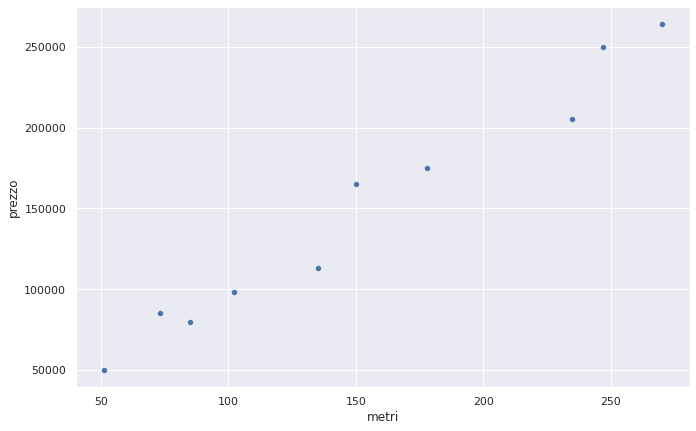

In [ ]:
sns.scatterplot(data = case, x = 'metri', y = 'prezzo')
plt.show()

In [ ]:
# definiamo e "fittiamo" il modello di regressione lineare
reg_case = LinearRegression()
reg_case.fit(X = case['metri'].values.reshape(-1, 1), 
             y = case['prezzo'])

LinearRegression()

In [ ]:
# Domanda Nr.1

# stampiamo a schermo i coefficienti della regressione
print('Intercetta (b0):', round(reg_case.intercept_, 2))
print('Coefficiente (b1):', round(reg_case.coef_[0], 2))

Intercetta (b0): 4156.56
Coefficiente (b1): 945.89


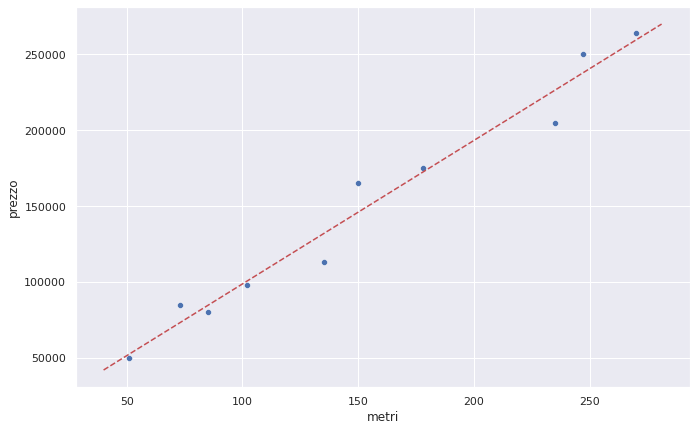

In [ ]:
# andiamo a rappresentare graficamente la retta che identifica il modello
# e la sovrapponiamo alla nuvola di punti dei nostri dati
sns.scatterplot(x='metri', y='prezzo', data=case)

intercept = reg_case.intercept_
slope = reg_case.coef_[0]

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color='r')

plt.show()

In [ ]:
# Domanda Nr. 2

prev_case = reg_case.coef_[0] * 110 + reg.intercept_
print(f'Prezzo previsto: { round(prev_case, 2) }')

Prezzo previsto: 111898.72


In [ ]:
# Domanda Nr. 3

x_nuove_case = np.array([55, 78, 145, 235, 350])
y_prev_case = reg.predict(x_nuove_case.reshape(-1, 1))
y_prev_case

array([7869.94221166, 7878.12815728, 7901.97417279, 7934.00613393,
       7974.93586205])